# Feature engineering, xgboost
https://www.kaggle.com/dlarionov/feature-engineering-xgboost


-　DateNum作成 'date_block_num',→YYYYMMで代用
- 祝日フラグ
- month
- days
- アイテムカテゴリ（デフォルト)-> カテゴリCategory、ジャンルType
- 月の売り上げ
### lag01
- 月の売り上げラグ 1,2,3,6,12
- アイテムあたりの「週Or日」平均販売個数 1,2,3,6,12　　'date_item_avg_item_cnt_lag_1',
- ショップあたり「週Or日」平均販売個数ラグ1，2，3，6，12　　'date_shop_avg_item_cnt_lag_1',
- アイテムカテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12'date_cat_avg_item_cnt_lag_1',
- カテゴリあたり「週Or日」平均販売個数ラグ1,2,3,6,12，'date_cat_avg_item_cnt_lag_1',
- ジャンル　あたり[月] 平均販売個数ラグ1,2,3,6,12
- アイテムカテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- カテゴリ/ショップあたり[月] 平均販売個数ラグ1,2,3,6,12
- ジャンル/ショップ　あたり[月] 平均販売個数ラグ1,2,3,6,12
- ASP　月当たり
### lag02
- 価格トレンド　過去6か月
- 店舗売上トレンド
- 価格下落率
- 最終販売日
- 初販売日
- ショップあたりの最終販売日
- ショップあたりの初販売日
    'delta_price_lag',


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
category_names = pd.read_csv('category_names.csv')
category_names.columns = ['ItemCategoryId', 'ItemCategoryName']

item_categories = pd.read_csv('item_categories.csv')
item_categories.columns = ['ItemId', 'ItemCategoryId']

sales_history = pd.read_csv('sales_history.csv')
sales_history.columns = ['Date', 'StoreId', 'ItemId', 'ItemPrice', 'SoldNum']
sales_history['Date'] = pd.to_datetime(sales_history['Date'])

test = pd.read_csv('test.csv')
test.columns = ['index', 'ItemId', 'StoreId']
#item_categories['ItemCategoryId'].unique()
#category_names.query('ItemCategoryName.str.contains("")')
'''170品目のリスト'''
test_item = test['ItemId'].unique()
test_item = pd.DataFrame({'ItemId':test_item})

'''年月のリスト'''
yyyymm = pd.read_csv('./csv/yyyymm.csv')

'''170品目と月番号加工済みデータ '''
#target = pd.read_csv('./csv/sales_170_date_block_asp_rev.csv')

''' ラグ01（販売個数トレンド+ASP+Revenue58特徴量'''
#lag01 = pd.read_csv('./csv/target_lag01.csv')
'''最終データ'''
data = pd.read_csv('./csv/matrix_final.csv')

#test_item
'''カテゴリ名と連結'''
ttest = pd.merge(test,item_categories, on='ItemId')
ttest = pd.merge(ttest, category_names,on='ItemCategoryId')
print('予測データの品目数: ',ttest['ItemId'].nunique(),'\n',
      '訓練データの品目数: ',sales_history['ItemId'].nunique(),'\n',
      '予測データのカテゴリ数: ',item_categories['ItemCategoryId'].nunique(),'\n',
      '訓練データのカテゴリ数: ',ttest['ItemCategoryId'].nunique(),'\n',
     '売上の総数: ',sales_history['SoldNum'].sum(), '\n',
     '')

予測データの品目数:  170 
 訓練データの品目数:  9040 
 予測データのカテゴリ数:  26 
 訓練データのカテゴリ数:  26 
 売上の総数:  1262869.0 
 


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12717 entries, 0 to 12716
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date_block_num                         12717 non-null  int64  
 1   YYYYMM                                 12717 non-null  int64  
 2   YYYY                                   12717 non-null  int64  
 3   MM                                     12717 non-null  int64  
 4   StoreId                                12717 non-null  int64  
 5   ItemId                                 12717 non-null  int64  
 6   ItemCategoryId                         12717 non-null  int64  
 7   Category                               12717 non-null  int64  
 8   Type                                   12717 non-null  int64  
 9   SoldNum                                12717 non-null  float64
 10  is_holiday                             12717 non-null  int64  
 11  Re

<AxesSubplot:>

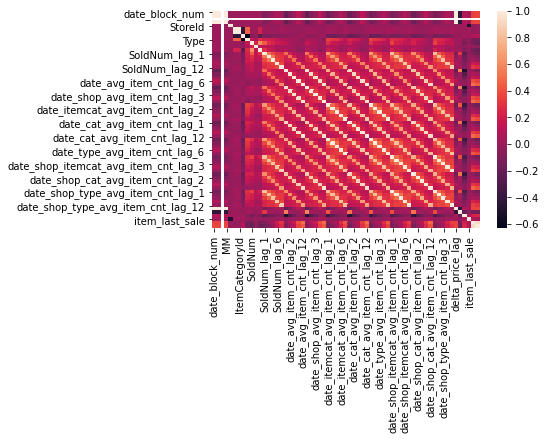

In [4]:
 sns.heatmap(data.corr())

In [5]:
data['date_block_num'].unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=int64)

In [6]:
data = data[['date_block_num', 
         'YYYYMM', 
         'YYYY',
         'MM', 
         'StoreId',
         'ItemId',
         'ItemCategoryId', 
         'Category',
         'Type',
         'SoldNum',
         'is_holiday',
         'Revenue', 
         'SoldNum_lag_1',
         'SoldNum_lag_2',
         'SoldNum_lag_3',
         'SoldNum_lag_6', 
         'SoldNum_lag_12', 
         'date_avg_item_cnt_lag_1',
         'date_avg_item_cnt_lag_2',
         'date_avg_item_cnt_lag_3',
         'date_avg_item_cnt_lag_6',
         'date_avg_item_cnt_lag_12',
         'date_shop_avg_item_cnt_lag_1',
         'date_shop_avg_item_cnt_lag_2',
         'date_shop_avg_item_cnt_lag_3', 
         'date_shop_avg_item_cnt_lag_6',
         'date_shop_avg_item_cnt_lag_12', 
         'date_itemcat_avg_item_cnt_lag_1',
         'date_itemcat_avg_item_cnt_lag_2', 
         'date_itemcat_avg_item_cnt_lag_3',
         'date_itemcat_avg_item_cnt_lag_6',
         'date_itemcat_avg_item_cnt_lag_12',
         'date_cat_avg_item_cnt_lag_1',
         'date_cat_avg_item_cnt_lag_2',
         'date_cat_avg_item_cnt_lag_3', 
         'date_cat_avg_item_cnt_lag_6',
         'date_cat_avg_item_cnt_lag_12', 
         'date_type_avg_item_cnt_lag_1',
         'date_type_avg_item_cnt_lag_2', 
         'date_type_avg_item_cnt_lag_3',
         'date_type_avg_item_cnt_lag_6', 
         'date_type_avg_item_cnt_lag_12',
         'date_shop_itemcat_avg_item_cnt_lag_1',
         'date_shop_itemcat_avg_item_cnt_lag_2',
         'date_shop_itemcat_avg_item_cnt_lag_3',
         'date_shop_itemcat_avg_item_cnt_lag_6',
         'date_shop_itemcat_avg_item_cnt_lag_12',
         'date_shop_cat_avg_item_cnt_lag_1', 
         'date_shop_cat_avg_item_cnt_lag_2',
         'date_shop_cat_avg_item_cnt_lag_3', 
         'date_shop_cat_avg_item_cnt_lag_6',
         'date_shop_cat_avg_item_cnt_lag_12',
         'date_shop_type_avg_item_cnt_lag_1',
         'date_shop_type_avg_item_cnt_lag_2',
         'date_shop_type_avg_item_cnt_lag_3',
         'date_shop_type_avg_item_cnt_lag_6',
         'date_shop_type_avg_item_cnt_lag_12', 
         'delta_price_lag',
         'delta_revenue_lag_1',
         'item_shop_last_sale',
         'item_last_sale',
         'item_shop_first_sale',
         'item_first_sale',
        ]]

# XGBoost

In [7]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [24]:
sales_month = data.groupby(['YYYY', 'MM', 'StoreId', 'ItemId'], as_index=False).sum()


,YYYY,MM,StoreId,ItemId,date_block_num,YYYYMM,ItemCategoryId,Category,Type,SoldNum,...,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,2019,1,0,1000001,12,201901,100,5,1,2.0,...,1.250,0.000,1.667,3.125,12.0,0.00000,2,1,12,12
1,2019,1,0,1000005,12,201901,100,5,1,1.0,...,1.250,1.571,1.667,3.125,12.0,1.02300,1,1,12,12
2,2019,1,0,1000006,12,201901,100,5,1,1.0,...,0.000,1.571,1.667,3.125,12.0,1.02300,1,1,12,12
3,2019,1,0,1000008,12,201901,100,5,1,1.0,...,0.000,1.571,1.667,3.125,12.0,1.02300,1,1,12,12
4,2019,1,0,1000010,12,201901,100,5,1,3.0,...,1.250,1.571,1.667,0.000,12.0,1.02300,1,1,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12712,2019,10,17,2900075,21,201910,290,1,22,6.0,...,0.000,0.000,0.000,0.000,21.0,0.10425,1,-1,1,1
12713,2019,10,17,3200001,21,201910,320,4,10,1.0,...,1.667,2.334,0.000,1.000,21.0,0.00000,2,-1,20,21
12714,2019,10,17,3200026,21,201910,320,4,10,4.0,...,1.667,2.334,0.000,0.000,21.0,0.10425,1,-1,8,9
12715,2019,10,17,3400001,21,201910,340,4,9,1.0,...,0.000,1.000,0.000,3.000,21.0,0.10425,1,-1,19,21


In [31]:
'''要修正''''
shop_id = np.arange(0, 18)
items = test['ItemId'].unique()
month_sales_df = pd.DataFrame()
#欠損値補完処理(処理時間計測開始)
start_time = time.time()

for id in shop_id:
    for item in items:
        tmp_df = yyyymm.copy()
        tmp_df['StoreID'] = id
        tmp_df['ItemId'] = item
        item_df = data[(data['ItemId'] == item) & 
                                   (data['StoreId'] == id)].drop(columns='StoreId')
        tmp_df = pd.merge(tmp_df, item_df, on=['YYYYMM', 'ItemId'], how='left').fillna(0)
        month_sales_df = month_sales_df.append(tmp_df)

end_time = time.time()
#計測終了

elasped_time = end_time - start_time
elasped_time

In [34]:
month_sales_df

,date_block_num_x,YYYYMM,StoreID,ItemId,date_block_num_y,YYYY,MM,ItemCategoryId,Category,Type,...,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,201801,0,1000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,201802,0,1000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,201803,0,1000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,201804,0,1000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,201805,0,1000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,201906,17,3500001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,18,201907,17,3500001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,19,201908,17,3500001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,20,201909,17,3500001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X_train = data[data.date_block_num < 18].drop(['SoldNum'], axis=1)
Y_train = data[data.date_block_num < 18]['SoldNum']
X_valid = data[data.date_block_num == 20].drop(['SoldNum'], axis=1)
Y_valid = data[data.date_block_num == 20]['SoldNum']

In [17]:
X_test = data.query('YYYYMM == 201910')
X_test = pd.merge(test,X_test, on=['StoreId','ItemId'],how='left')
X_test.fillna(0,inplace=True)
X_test.drop('index',axis=1,inplace=True)
X_test['date_block_num'] =21
X_test

,ItemId,StoreId,date_block_num,YYYYMM,YYYY,MM,ItemCategoryId,Category,Type,SoldNum,...,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,1000001,0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
1,1000001,1,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
2,1000001,2,21,201910.0,2019.0,10.0,100.0,5.0,1.0,2.0,...,1.444,0.000,2.285,1.000,21.0,0.00000,2.0,1.0,21.0,21.0
3,1000001,3,21,201910.0,2019.0,10.0,100.0,5.0,1.0,2.0,...,2.400,1.889,2.445,2.500,21.0,-0.12950,1.0,-1.0,21.0,21.0
4,1000001,4,21,201910.0,2019.0,10.0,100.0,5.0,1.0,12.0,...,2.900,2.834,2.666,2.334,21.0,0.32810,1.0,-1.0,20.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,3500001,13,21,201910.0,2019.0,10.0,350.0,6.0,6.0,2.0,...,1.000,1.000,0.000,2.000,21.0,-0.05292,1.0,-1.0,21.0,21.0
3056,3500001,14,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
3057,3500001,15,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
3058,3500001,16,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0


In [18]:
X_test = X_test.drop(['SoldNum'], axis=1)
X_test

,ItemId,StoreId,date_block_num,YYYYMM,YYYY,MM,ItemCategoryId,Category,Type,is_holiday,...,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,1000001,0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
1,1000001,1,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
2,1000001,2,21,201910.0,2019.0,10.0,100.0,5.0,1.0,0.0,...,1.444,0.000,2.285,1.000,21.0,0.00000,2.0,1.0,21.0,21.0
3,1000001,3,21,201910.0,2019.0,10.0,100.0,5.0,1.0,0.0,...,2.400,1.889,2.445,2.500,21.0,-0.12950,1.0,-1.0,21.0,21.0
4,1000001,4,21,201910.0,2019.0,10.0,100.0,5.0,1.0,0.0,...,2.900,2.834,2.666,2.334,21.0,0.32810,1.0,-1.0,20.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,3500001,13,21,201910.0,2019.0,10.0,350.0,6.0,6.0,0.0,...,1.000,1.000,0.000,2.000,21.0,-0.05292,1.0,-1.0,21.0,21.0
3056,3500001,14,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
3057,3500001,15,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0
3058,3500001,16,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.00000,0.0,0.0,0.0,0.0


In [19]:
%time
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


Wall time: 0 ns
[18:21:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.46741	validation_1-rmse:1.83007
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.33868	validation_1-rmse:1.70102
[2]	validation_0-rmse:2.23285	validation_1-rmse:1.59555
[3]	validation_0-rmse:2.13815	validation_1-rmse:1.49627
[4]	validation_0-rmse:2.04873	validation_1-rmse:1.40987
[5]	validation_0-rmse:1.97278	validation_1-rmse:1.33589
[6]	validation_0-rmse:1.90827	validation_1-rmse:1.27554
[7]	validation_0-rmse:1.85377	validation_1-rmse:1.22581
[8]	validation_0-rmse:1.80427	validation_1-rmse:1.18346
[9]	validation_0-rmse:1.76241	validation_1-rmse:1.14016
[10]	validation_0-rmse:1.72623	validation_1-rmse:1.11118
[11]	validation_0-rmse:1.69445	validation_1-rmse:1.0871
[12]	validation_0-rmse:1.66501	valid

XGBRegressor(colsample_bytree=0.8, eta=0.3, max_depth=8, min_child_weight=300,
             n_estimators=1000, seed=42, subsample=0.8)

In [20]:
Y_pred = model.predict(X_valid)
Y_test = model.predict(X_test)

ValueError: feature_names mismatch: ['date_block_num', 'YYYYMM', 'YYYY', 'MM', 'StoreId', 'ItemId', 'ItemCategoryId', 'Category', 'Type', 'is_holiday', 'Revenue', 'SoldNum_lag_1', 'SoldNum_lag_2', 'SoldNum_lag_3', 'SoldNum_lag_6', 'SoldNum_lag_12', 'date_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_2', 'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6', 'date_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12', 'date_itemcat_avg_item_cnt_lag_1', 'date_itemcat_avg_item_cnt_lag_2', 'date_itemcat_avg_item_cnt_lag_3', 'date_itemcat_avg_item_cnt_lag_6', 'date_itemcat_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_12', 'date_type_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_2', 'date_type_avg_item_cnt_lag_3', 'date_type_avg_item_cnt_lag_6', 'date_type_avg_item_cnt_lag_12', 'date_shop_itemcat_avg_item_cnt_lag_1', 'date_shop_itemcat_avg_item_cnt_lag_2', 'date_shop_itemcat_avg_item_cnt_lag_3', 'date_shop_itemcat_avg_item_cnt_lag_6', 'date_shop_itemcat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_6', 'date_shop_cat_avg_item_cnt_lag_12', 'date_shop_type_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_2', 'date_shop_type_avg_item_cnt_lag_3', 'date_shop_type_avg_item_cnt_lag_6', 'date_shop_type_avg_item_cnt_lag_12', 'delta_price_lag', 'delta_revenue_lag_1', 'item_shop_last_sale', 'item_last_sale', 'item_shop_first_sale', 'item_first_sale'] ['ItemId', 'StoreId', 'date_block_num', 'YYYYMM', 'YYYY', 'MM', 'ItemCategoryId', 'Category', 'Type', 'is_holiday', 'Revenue', 'SoldNum_lag_1', 'SoldNum_lag_2', 'SoldNum_lag_3', 'SoldNum_lag_6', 'SoldNum_lag_12', 'date_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_2', 'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6', 'date_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12', 'date_itemcat_avg_item_cnt_lag_1', 'date_itemcat_avg_item_cnt_lag_2', 'date_itemcat_avg_item_cnt_lag_3', 'date_itemcat_avg_item_cnt_lag_6', 'date_itemcat_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_12', 'date_type_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_2', 'date_type_avg_item_cnt_lag_3', 'date_type_avg_item_cnt_lag_6', 'date_type_avg_item_cnt_lag_12', 'date_shop_itemcat_avg_item_cnt_lag_1', 'date_shop_itemcat_avg_item_cnt_lag_2', 'date_shop_itemcat_avg_item_cnt_lag_3', 'date_shop_itemcat_avg_item_cnt_lag_6', 'date_shop_itemcat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_6', 'date_shop_cat_avg_item_cnt_lag_12', 'date_shop_type_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_2', 'date_shop_type_avg_item_cnt_lag_3', 'date_shop_type_avg_item_cnt_lag_6', 'date_shop_type_avg_item_cnt_lag_12', 'delta_price_lag', 'delta_revenue_lag_1', 'item_shop_last_sale', 'item_last_sale', 'item_shop_first_sale', 'item_first_sale']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

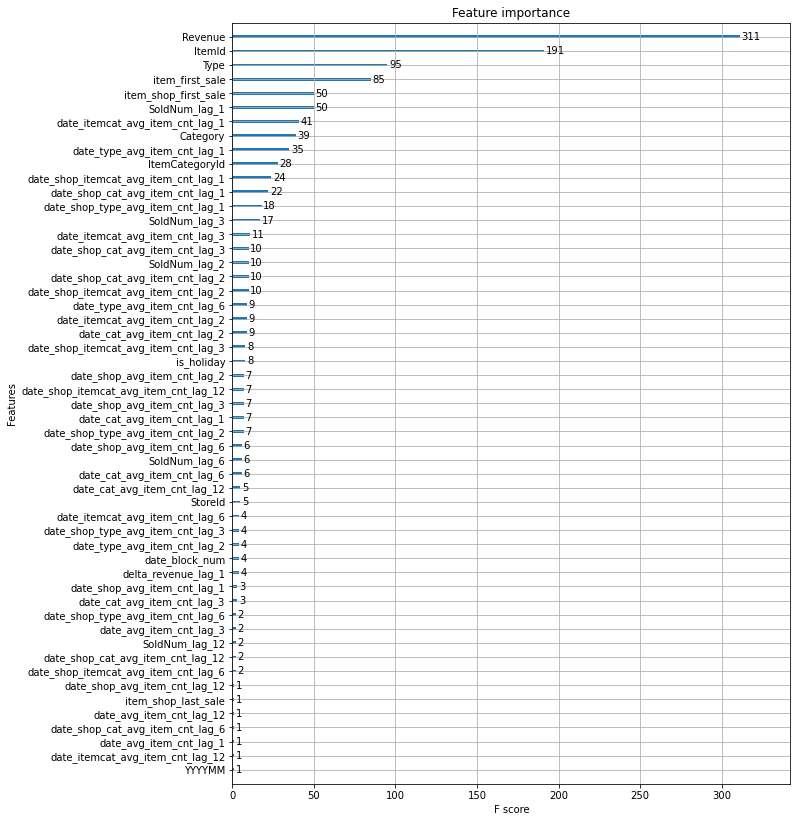

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(model,ax)

In [15]:
Y_test.shape

(1169,)